### Data Sources

##### 1. https://www.kaggle.com/plameneduardo/sarscov2-ctscan-dataset (Brazil) - .PNG
##### 2. https://www.kaggle.com/luisblanche/covidct (Mixed) - .JPG

Training the Model on Brazil's Data and testing its performance on Mixed Data was giving poor results.

Combining both data sets for training the model

### Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading required Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
palette = sns.color_palette("bright", 10)
sns.set(rc={'figure.figsize':(12,8)})

from skimage.transform import resize
from skimage import feature
import cv2
from google.colab.patches import cv2_imshow
import PIL
from PIL import Image
from PIL import ImageEnhance

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch import autograd
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable

### Function to Measure the Model Performance

In [ ]:
def accuracy_metrics(y, y_pred, y_prob):
    results = confusion_matrix(y, y_pred) 
    print('Confusion Matrix :')
    print(results) 
    print('Accuracy :  ', round(accuracy_score(y, y_pred), 3))
    print('Precision : ', round(precision_score(y, y_pred), 3))
    print('Recall :    ', round(recall_score(y, y_pred), 3))
    print('FI Score :  ', round(f1_score(y, y_pred), 3))
    print('AUC :       ', round(roc_auc_score(y, y_prob), 3))

### Data Size

In [ ]:
combined_path = "/content/drive/MyDrive/MTECH AI/Semester 3/Computer Vision/CV_Project/Data/Combined_Data/"
data_size_combined = len(glob.glob(combined_path + "*/*"))

print(data_size_combined)

2968


There are 2 different data sources. 1st source has CT Scan images in .PNG format from Brazil whereas, 2nd data source has images from China in .JPG format. Both data sets will be combined and ranomly split into train, test & validation.

### 1. ResNet34 from Scratch on Combined Data Sources for Training & Testing without Image Enhancement

### Data Loader

In [ ]:
#custom dataset
class CustomDataset(Dataset):
    def __init__(self, path, img_dim = (224, 224)):
        self.imgs_path = path
        file_list = glob.glob(self.imgs_path + "*")
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("/")[-1]
            for img_path in glob.glob(class_path + "*/*"):
                self.data.append([img_path, class_name])
        self.class_map = {"Non_Covid" : 0, "Covid": 1}
        self.img_dim = img_dim
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        img = cv2.resize(img, self.img_dim)
        class_id = self.class_map[class_name]
        img_tensor = torch.from_numpy(img/255.)
        img_tensor = img_tensor.permute(2, 0, 1)
        class_id = torch.tensor([class_id])
        return img_tensor, class_id.squeeze()

#### Loading Train, Test & Validation Data

In [ ]:
#data utilitiesa
random_state = 100
batch_size = 16
validation_split = 0.15
indices = list(range(data_size_combined))
split = int(np.floor(validation_split * data_size_combined))

#indices for training and validation splits:
np.random.seed(random_state)
np.random.shuffle(indices)

train_indices, val_indices, test_indices = indices[2*split:], indices[:split], indices[split:2*split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

dataset = CustomDataset(path = combined_path)
train_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, sampler = train_sampler, num_workers = 2)
val_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, sampler = val_sampler, num_workers = 2)
test_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, sampler = test_sampler, num_workers = 2)

#### CNN Model Structure

In [ ]:
#downloading pre trained resnet18 model
model = models.resnet34(pretrained = False)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#changing classification layer
model.fc = nn.Linear(512, 2)

#set device to be cude
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

#model structure
print(model)
summary(model, (3, 224, 224))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Loss & Optimizer

In [ ]:
#loss & optimizer
criterion = nn.CrossEntropyLoss().to(device)                                                                     #loss
optimizer = optim.Adamax(model.parameters(), weight_decay = 1e-6)                                                #optimizer
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience = 5, factor = 0.3, min_lr = 1e-4)    #learning rate scheduler

#### Model Training

In [ ]:
#training
start_epoch = 0
epochs = 50

best_val_acc = 0

print('Started Training ... !!!')

for epoch in range(start_epoch, epochs + start_epoch):

    train_loss = 0.0
    train_correct = 0.0
    items = 0

    model.train()
    for data in train_loader:
        # get the inputs
        inputs, labels = data[0], data[1]

        items += len(inputs)
        
        #change inputs to cuda type
        inputs = inputs.to(device = device, dtype = torch.float)
        labels = labels.to(device = device)

        #wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        #zero the parameter gradients
        optimizer.zero_grad()
        
        #forward + backward + optimize
        pred_train = model(inputs)                                     #prediction
        pred_train_probs = torch.softmax(pred_train, dim = 1)          #predicted probability
        loss_t = criterion(pred_train_probs, labels)                   #calculate loss
        
        _, pred_train_labels = torch.max(pred_train_probs, 1)          #assigning class label to prediction
        train_correct += (pred_train_labels == labels).sum().item()    #count correct preditions  

        loss_t.backward()                                              #backpropogate
        optimizer.step()                                               #update weights

        train_loss += loss_t.item()                                    #update loss

    #normalizing the loss & accuracy by the total number of train batches
    train_loss /= len(train_loader)
    train_acc =  (train_correct * 100) / items


    #MODEL VALIDATION
    with torch.no_grad():
         model.eval()
         val_loss = 0.0
         val_correct = 0.0
         val_items = 0
         
         for data_val in val_loader:    #get the inputs
             val_inputs, val_labels = data_val[0], data_val[1]

             val_items += len(val_inputs)

             #converting input and labels to cuda 
             val_inputs = val_inputs.to(device = device, dtype = torch.float)
             val_labels = val_labels.to(device = device)

             #wrap them in Variable
             val_inputs, val_labels = Variable(val_inputs), Variable(val_labels)

             pred_val = model(val_inputs)                                   #prediction
             pred_val_probs = torch.softmax(pred_val, dim = 1)              #predicted probability
             loss_v = criterion(pred_val_probs, val_labels)                 #calculate loss
             
             _, pred_val_labels = torch.max(pred_val_probs, 1)              #assigning class label to prediction
             val_correct += (pred_val_labels == val_labels).sum().item()    #count correct predictions

             val_loss += loss_v.item()                                      #update loss
          
         #normalizing the loss by the total number of val batches
         val_loss /= len(val_loader)
         val_acc =  (val_correct * 100) / val_items

         #save the best model
         if val_acc > best_val_acc:
            torch.save(model.state_dict(), '/content/drive/MyDrive/MTECH AI/Semester 3/Computer Vision/CV_Project/Saved_Models/resnet_ct_raw_combined.pth')   #save model
            best_val_acc = val_acc         #change best val accuracy

         scheduler.step(val_acc)
        
    print(f'Epoch {epoch + 1}: | Train Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.3f} % | Validation Loss: {val_loss:.5f} | Validation Accuracy: {val_acc:.3f} %')

print('Finished Training ... !!!')

Started Training ... !!!
Epoch 1: | Train Loss: 0.64681 | Train Accuracy: 65.255 % | Validation Loss: 0.58415 | Validation Accuracy: 71.461 %
Epoch 2: | Train Loss: 0.56093 | Train Accuracy: 74.639 % | Validation Loss: 0.77868 | Validation Accuracy: 52.135 %
Epoch 3: | Train Loss: 0.54899 | Train Accuracy: 75.505 % | Validation Loss: 0.86922 | Validation Accuracy: 43.820 %
Epoch 4: | Train Loss: 0.52497 | Train Accuracy: 77.671 % | Validation Loss: 0.56810 | Validation Accuracy: 72.584 %
Epoch 5: | Train Loss: 0.54791 | Train Accuracy: 75.746 % | Validation Loss: 0.61957 | Validation Accuracy: 67.640 %
Epoch 6: | Train Loss: 0.51853 | Train Accuracy: 79.018 % | Validation Loss: 0.54321 | Validation Accuracy: 75.955 %
Epoch 7: | Train Loss: 0.50007 | Train Accuracy: 80.558 % | Validation Loss: 0.48224 | Validation Accuracy: 83.596 %
Epoch 8: | Train Loss: 0.50289 | Train Accuracy: 80.269 % | Validation Loss: 0.56724 | Validation Accuracy: 74.157 %
Epoch 9: | Train Loss: 0.49085 | Train 

#### Checking Model Performance

In [ ]:
#loading best model
state_dict = torch.load('/content/drive/MyDrive/MTECH AI/Semester 3/Computer Vision/CV_Project/Saved_Models/resnet_ct_raw_combined.pth')
model.load_state_dict(state_dict)

#checking model performance on train, validation & test data
y_true = []
y_prob = []
y_pred = []

with torch.no_grad():
    for data in train_loader:
        inputs, labels = data[0].to(device), data[1].to(device)                 #X & y
        inputs = inputs.to(device = device, dtype = torch.float)
        outputs = model(inputs)  #prediction
        outputs_probs = torch.softmax(outputs, dim = 1)              #predicted probability
        _, predicted = torch.max(outputs_probs, 1)                   #assigning class label to prediction
        y_true.extend(list(labels.detach().cpu().numpy()))
        y_prob.extend(list(outputs_probs.detach().cpu().numpy()[:, 1]))
        y_pred.extend(list(predicted.detach().cpu().numpy()))

print('Performance Metrics on Train Data: ')
print(accuracy_metrics(y_true, y_pred, y_prob))
print("\n")


y_true = []
y_prob = []
y_pred = []

with torch.no_grad():
    for data in val_loader:
        inputs, labels = data[0].to(device), data[1].to(device)                 #X & y
        inputs = inputs.to(device = device, dtype = torch.float)
        outputs = model(inputs)  #prediction
        outputs_probs = torch.softmax(outputs, dim = 1)              #predicted probability
        _, predicted = torch.max(outputs_probs, 1)                   #assigning class label to prediction
        y_true.extend(list(labels.detach().cpu().numpy()))
        y_prob.extend(list(outputs_probs.detach().cpu().numpy()[:, 1]))
        y_pred.extend(list(predicted.detach().cpu().numpy()))

print('Performance Metrics on Validation Data: ')
print(accuracy_metrics(y_true, y_pred, y_prob))
print("\n")


y_true = []
y_prob = []
y_pred = []

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)                 #X & y
        inputs = inputs.to(device = device, dtype = torch.float)
        outputs = model(inputs)  #prediction
        outputs_probs = torch.softmax(outputs, dim = 1)              #predicted probability
        _, predicted = torch.max(outputs_probs, 1)                   #assigning class label to prediction
        y_true.extend(list(labels.detach().cpu().numpy()))
        y_prob.extend(list(outputs_probs.detach().cpu().numpy()[:, 1]))
        y_pred.extend(list(predicted.detach().cpu().numpy()))

print('Performance Metrics on Test Data: ')
print(accuracy_metrics(y_true, y_pred, y_prob))

Performance Metrics on Train Data: 
Confusion Matrix :
[[ 983   48]
 [  39 1008]]
Accuracy :   0.958
Precision :  0.955
Recall :     0.963
FI Score :   0.959
AUC :        0.953
None


Performance Metrics on Validation Data: 
Confusion Matrix :
[[209  24]
 [ 10 202]]
Accuracy :   0.924
Precision :  0.894
Recall :     0.953
FI Score :   0.922
AUC :        0.934
None


Performance Metrics on Test Data: 
Confusion Matrix :
[[209  15]
 [ 14 207]]
Accuracy :   0.935
Precision :  0.932
Recall :     0.937
FI Score :   0.935
AUC :        0.968
None


### 2. ResNet34 Transfer Learning on Combined Data Sources for Training without Data Augmentation

### Data Loader

In [ ]:
#custom dataset
class CustomDataset(Dataset):
    def __init__(self, path, img_dim = (224, 224)):
        self.imgs_path = path
        file_list = glob.glob(self.imgs_path + "*")
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("/")[-1]
            for img_path in glob.glob(class_path + "*/*"):
                self.data.append([img_path, class_name])
        self.class_map = {"Non_Covid" : 0, "Covid": 1}
        self.img_dim = img_dim
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        img = cv2.resize(img, self.img_dim)
        class_id = self.class_map[class_name]
        img_tensor = torch.from_numpy(img/255.)
        img_tensor = img_tensor.permute(2, 0, 1)
        class_id = torch.tensor([class_id])
        return img_tensor, class_id.squeeze()

#### Loading Train, Test & Validation Data

In [ ]:
#data utilitiesa
random_state = 100
batch_size = 16
validation_split = 0.15
indices = list(range(data_size_combined))
split = int(np.floor(validation_split * data_size_combined))

#indices for training and validation splits:
np.random.seed(random_state)
np.random.shuffle(indices)

train_indices, val_indices, test_indices = indices[2*split:], indices[:split], indices[split:2*split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

dataset = CustomDataset(path = combined_path)
train_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, sampler = train_sampler, num_workers = 2)
val_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, sampler = val_sampler, num_workers = 2)
test_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, sampler = test_sampler, num_workers = 2)

#### CNN Model Structure

In [ ]:
#downloading pre trained resnet18 model
model = models.resnet34(pretrained = True, progress = True)
print(model)

#freezing model weights
for param in model.parameters():
    param.requires_grad = False

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#unfreezing last convolution block
for param in model.layer4.parameters():
    param.requires_grad = True

In [ ]:
#defining a 1 layer neural network
model.fc = nn.Linear(512, 2)

#unfreezing last convolution block
for param in model.fc.parameters():
    param.requires_grad = True

#set device to be cude
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

#model structure
print(model)
summary(model, (3, 224, 224))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Loss & Optimizer

In [ ]:
#loss & optimizer
criterion = nn.CrossEntropyLoss().to(device)                                                                      #loss
optimizer = optim.Adamax(model.parameters(), weight_decay = 1e-3)                                                 #optimizer
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience = 5, factor = 0.3, min_lr = 1e-4)    #learning rate scheduler

#### Model Training

In [ ]:
#training
start_epoch = 0
epochs = 50

best_val_acc = 0

print('Started Training ... !!!')

for epoch in range(start_epoch, epochs + start_epoch):

    train_loss = 0.0
    train_correct = 0.0
    items = 0

    model.train()
    for data in train_loader:
        # get the inputs
        inputs, labels = data[0], data[1]

        items += len(inputs)
        
        #change inputs to cuda type
        inputs = inputs.to(device = device, dtype = torch.float)
        labels = labels.to(device = device)

        #wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        #zero the parameter gradients
        optimizer.zero_grad()
        
        #forward + backward + optimize
        pred_train = model(inputs)                                     #prediction
        pred_train_probs = torch.softmax(pred_train, dim = 1)          #predicted probability
        loss_t = criterion(pred_train_probs, labels)                   #calculate loss
        
        _, pred_train_labels = torch.max(pred_train_probs, 1)          #assigning class label to prediction
        train_correct += (pred_train_labels == labels).sum().item()    #count correct preditions  

        loss_t.backward()                                              #backpropogate
        optimizer.step()                                               #update weights

        train_loss += loss_t.item()                                    #update loss

    #normalizing the loss & accuracy by the total number of train batches
    train_loss /= len(train_loader)
    train_acc =  (train_correct * 100) / items


    #MODEL VALIDATION
    with torch.no_grad():
         model.eval()
         val_loss = 0.0
         val_correct = 0.0
         val_items = 0
         
         for data_val in val_loader:    #get the inputs
             val_inputs, val_labels = data_val[0], data_val[1]

             val_items += len(val_inputs)

             #converting input and labels to cuda 
             val_inputs = val_inputs.to(device = device, dtype = torch.float)
             val_labels = val_labels.to(device = device)

             #wrap them in Variable
             val_inputs, val_labels = Variable(val_inputs), Variable(val_labels)

             pred_val = model(val_inputs)                                   #prediction
             pred_val_probs = torch.softmax(pred_val, dim = 1)              #predicted probability
             loss_v = criterion(pred_val_probs, val_labels)                 #calculate loss
             
             _, pred_val_labels = torch.max(pred_val_probs, 1)              #assigning class label to prediction
             val_correct += (pred_val_labels == val_labels).sum().item()    #count correct predictions

             val_loss += loss_v.item()                                      #update loss
          
         #normalizing the loss by the total number of val batches
         val_loss /= len(val_loader)
         val_acc =  (val_correct * 100) / val_items

         #save the best model
         if val_acc > best_val_acc:
            torch.save(model.state_dict(), '/content/drive/MyDrive/MTECH AI/Semester 3/Computer Vision/CV_Project/Saved_Models/resnet_transfer_ct_raw_combined.pth')   #save model
            best_val_acc = val_acc         #change best val accuracy

         scheduler.step(val_acc)
        
    print(f'Epoch {epoch + 1}: | Train Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.3f} % | Validation Loss: {val_loss:.5f} | Validation Accuracy: {val_acc:.3f} %')

print('Finished Training ... !!!')

Started Training ... !!!
Epoch 1: | Train Loss: 0.49803 | Train Accuracy: 80.895 % | Validation Loss: 0.44450 | Validation Accuracy: 87.191 %
Epoch 2: | Train Loss: 0.43070 | Train Accuracy: 88.114 % | Validation Loss: 0.42356 | Validation Accuracy: 88.090 %
Epoch 3: | Train Loss: 0.39974 | Train Accuracy: 91.290 % | Validation Loss: 0.42357 | Validation Accuracy: 88.989 %
Epoch 4: | Train Loss: 0.38777 | Train Accuracy: 92.397 % | Validation Loss: 0.43114 | Validation Accuracy: 88.539 %
Epoch 5: | Train Loss: 0.38045 | Train Accuracy: 93.359 % | Validation Loss: 0.43734 | Validation Accuracy: 87.640 %
Epoch 6: | Train Loss: 0.36516 | Train Accuracy: 94.899 % | Validation Loss: 0.42515 | Validation Accuracy: 87.640 %
Epoch 7: | Train Loss: 0.35420 | Train Accuracy: 96.198 % | Validation Loss: 0.37988 | Validation Accuracy: 93.933 %
Epoch 8: | Train Loss: 0.34340 | Train Accuracy: 97.161 % | Validation Loss: 0.38573 | Validation Accuracy: 92.584 %
Epoch 9: | Train Loss: 0.34523 | Train 

#### Checking Model Performance

In [ ]:
#loading best model
state_dict = torch.load('/content/drive/MyDrive/MTECH AI/Semester 3/Computer Vision/CV_Project/Saved_Models/resnet_transfer_ct_raw_combined.pth')
model.load_state_dict(state_dict)

#checking model performance on train, validation & test data
y_true = []
y_prob = []
y_pred = []

with torch.no_grad():
    for data in train_loader:
        inputs, labels = data[0].to(device), data[1].to(device)                 #X & y
        inputs = inputs.to(device = device, dtype = torch.float)
        outputs = model(inputs)  #prediction
        outputs_probs = torch.softmax(outputs, dim = 1)              #predicted probability
        _, predicted = torch.max(outputs_probs, 1)                   #assigning class label to prediction
        y_true.extend(list(labels.detach().cpu().numpy()))
        y_prob.extend(list(outputs_probs.detach().cpu().numpy()[:, 1]))
        y_pred.extend(list(predicted.detach().cpu().numpy()))

print('Performance Metrics on Train Data: ')
print(accuracy_metrics(y_true, y_pred, y_prob))
print("\n")


y_true = []
y_prob = []
y_pred = []

with torch.no_grad():
    for data in val_loader:
        inputs, labels = data[0].to(device), data[1].to(device)                 #X & y
        inputs = inputs.to(device = device, dtype = torch.float)
        outputs = model(inputs)  #prediction
        outputs_probs = torch.softmax(outputs, dim = 1)              #predicted probability
        _, predicted = torch.max(outputs_probs, 1)                   #assigning class label to prediction
        y_true.extend(list(labels.detach().cpu().numpy()))
        y_prob.extend(list(outputs_probs.detach().cpu().numpy()[:, 1]))
        y_pred.extend(list(predicted.detach().cpu().numpy()))

print('Performance Metrics on Validation Data: ')
print(accuracy_metrics(y_true, y_pred, y_prob))
print("\n")


y_true = []
y_prob = []
y_pred = []

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)                 #X & y
        inputs = inputs.to(device = device, dtype = torch.float)
        outputs = model(inputs)  #prediction
        outputs_probs = torch.softmax(outputs, dim = 1)              #predicted probability
        _, predicted = torch.max(outputs_probs, 1)                   #assigning class label to prediction
        y_true.extend(list(labels.detach().cpu().numpy()))
        y_prob.extend(list(outputs_probs.detach().cpu().numpy()[:, 1]))
        y_pred.extend(list(predicted.detach().cpu().numpy()))

print('Performance Metrics on Test Data: ')
print(accuracy_metrics(y_true, y_pred, y_prob))

Performance Metrics on Train Data: 
Confusion Matrix :
[[1030    1]
 [   0 1047]]
Accuracy :   1.0
Precision :  0.999
Recall :     1.0
FI Score :   1.0
AUC :        1.0
None


Performance Metrics on Validation Data: 
Confusion Matrix :
[[216  17]
 [  5 207]]
Accuracy :   0.951
Precision :  0.924
Recall :     0.976
FI Score :   0.95
AUC :        0.987
None


Performance Metrics on Test Data: 
Confusion Matrix :
[[219   5]
 [  8 213]]
Accuracy :   0.971
Precision :  0.977
Recall :     0.964
FI Score :   0.97
AUC :        0.99
None


### 3. ResNet34 Transfer Learning on Combined Data Sources for Training with Data Augmentation including Enhanced Images

### Data Loader

In [ ]:
#custom dataset
class CustomDataset(Dataset):
    def __init__(self, path, img_dim = (224, 224), transformation = False,  transformation_func = None):
        self.imgs_path = path
        file_list = glob.glob(self.imgs_path + "*")
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("/")[-1]
            for img_path in glob.glob(class_path + "*/*"):
                self.data.append([img_path, class_name])
        self.class_map = {"Non_Covid" : 0, "Covid": 1}
        self.img_dim = img_dim
        self.transformation = transformation
        self.transformation_func = transformation_func
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.img_dim)
        if self.transformation:
           img = self.transformation_func(Image.fromarray(img))  
        class_id = self.class_map[class_name]
        img_tensor = torch.from_numpy(np.array(img)/255.)
        img_tensor = img_tensor.permute(2, 0, 1)
        class_id = torch.tensor([class_id])
        return img_tensor, class_id.squeeze()

#### Loading Train, Test & Validation Data

In [ ]:
#data utilitiesa
random_state = 100
batch_size = 16
validation_split = 0.15
indices = list(range(data_size_combined))
split = int(np.floor(validation_split * data_size_combined))

#indices for training and validation splits:
np.random.seed(random_state)
np.random.shuffle(indices)

train_indices, val_indices, test_indices = indices[2*split:], indices[:split], indices[split:2*split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

#transformations
transform_ = torchvision.transforms.RandomChoice([torchvision.transforms.ColorJitter(brightness = 0, contrast = 0, saturation = 0, hue = 0),
                                                  torchvision.transforms.ColorJitter(brightness = 0, contrast = (1.25, 1.75), saturation = 0, hue = 0),
                                                  torchvision.transforms.ColorJitter(brightness = (1.2, 1.5), contrast = 0, saturation = 0, hue = 0),
                                                  torchvision.transforms.ColorJitter(brightness = (1.2, 1.5), contrast = (1.25, 1.75), saturation = 0, hue = 0),
                                                  torchvision.transforms.RandomRotation(degrees = (-10, 10))])

#dataloaders
dataset = CustomDataset(path = combined_path, transformation = True,  transformation_func = transform_)
dataset_ = CustomDataset(path = combined_path, transformation = False)
train_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, sampler = train_sampler, num_workers = 2)
val_loader = torch.utils.data.DataLoader(dataset_, batch_size = batch_size, sampler = val_sampler, num_workers = 2)
test_loader = torch.utils.data.DataLoader(dataset_, batch_size = batch_size, sampler = test_sampler, num_workers = 2)

#### CNN Model Structure

In [ ]:
#downloading pre trained resnet18 model
model = models.resnet34(pretrained = True, progress = True)
print(model)

#freezing model weights
for param in model.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [ ]:
#unfreezing last convolution block
for param in model.layer4.parameters():
    param.requires_grad = True

In [ ]:
#defining a 1 layer neural network
model.fc = nn.Linear(512, 2)

#unfreezing last convolution block
for param in model.fc.parameters():
    param.requires_grad = True

#set device to be cude
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

#model structure
print(model)
summary(model, (3, 224, 224))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Loss & Optimizer

In [ ]:
#loss & optimizer
criterion = nn.CrossEntropyLoss().to(device)                                                                      #loss
optimizer = optim.Adamax(model.parameters(), weight_decay = 1e-3)                                                 #optimizer
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience = 5, factor = 0.3, min_lr = 1e-4)    #learning rate scheduler

#### Model Training

In [ ]:
#training
start_epoch = 0
epochs = 100

best_val_acc = 0

print('Started Training ... !!!')

for epoch in range(start_epoch, epochs + start_epoch):

    train_loss = 0.0
    train_correct = 0.0
    items = 0

    model.train()
    for data in train_loader:
        # get the inputs
        inputs, labels = data[0], data[1]

        items += len(inputs)
        
        #change inputs to cuda type
        inputs = inputs.to(device = device, dtype = torch.float)
        labels = labels.to(device = device)

        #wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        #zero the parameter gradients
        optimizer.zero_grad()
        
        #forward + backward + optimize
        pred_train = model(inputs)                                     #prediction
        pred_train_probs = torch.softmax(pred_train, dim = 1)          #predicted probability
        loss_t = criterion(pred_train_probs, labels)                   #calculate loss
        
        _, pred_train_labels = torch.max(pred_train_probs, 1)          #assigning class label to prediction
        train_correct += (pred_train_labels == labels).sum().item()    #count correct preditions  

        loss_t.backward()                                              #backpropogate
        optimizer.step()                                               #update weights

        train_loss += loss_t.item()                                    #update loss

    #normalizing the loss & accuracy by the total number of train batches
    train_loss /= len(train_loader)
    train_acc =  (train_correct * 100) / items


    #MODEL VALIDATION
    with torch.no_grad():
         model.eval()
         val_loss = 0.0
         val_correct = 0.0
         val_items = 0
         
         for data_val in val_loader:    #get the inputs
             val_inputs, val_labels = data_val[0], data_val[1]

             val_items += len(val_inputs)

             #converting input and labels to cuda 
             val_inputs = val_inputs.to(device = device, dtype = torch.float)
             val_labels = val_labels.to(device = device)

             #wrap them in Variable
             val_inputs, val_labels = Variable(val_inputs), Variable(val_labels)

             pred_val = model(val_inputs)                                   #prediction
             pred_val_probs = torch.softmax(pred_val, dim = 1)              #predicted probability
             loss_v = criterion(pred_val_probs, val_labels)                 #calculate loss
             
             _, pred_val_labels = torch.max(pred_val_probs, 1)              #assigning class label to prediction
             val_correct += (pred_val_labels == val_labels).sum().item()    #count correct predictions

             val_loss += loss_v.item()                                      #update loss
          
         #normalizing the loss by the total number of val batches
         val_loss /= len(val_loader)
         val_acc =  (val_correct * 100) / val_items

         #save the best model
         if val_acc > best_val_acc:
            torch.save(model.state_dict(), '/content/drive/MyDrive/MTECH AI/Semester 3/Computer Vision/CV_Project/Saved_Models/resnet_transfer_ct_augment_combined.pth')   #save model
            best_val_acc = val_acc         #change best val accuracy

         scheduler.step(val_acc)
        
    print(f'Epoch {epoch + 1}: | Train Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.3f} % | Validation Loss: {val_loss:.5f} | Validation Accuracy: {val_acc:.3f} %')

print('Finished Training ... !!!')

Started Training ... !!!
Epoch 1: | Train Loss: 0.56750 | Train Accuracy: 73.917 % | Validation Loss: 0.46754 | Validation Accuracy: 82.921 %
Epoch 2: | Train Loss: 0.48589 | Train Accuracy: 81.665 % | Validation Loss: 0.45122 | Validation Accuracy: 85.843 %
Epoch 3: | Train Loss: 0.44055 | Train Accuracy: 86.910 % | Validation Loss: 0.42170 | Validation Accuracy: 89.213 %
Epoch 4: | Train Loss: 0.42771 | Train Accuracy: 88.162 % | Validation Loss: 0.41559 | Validation Accuracy: 89.663 %
Epoch 5: | Train Loss: 0.41624 | Train Accuracy: 89.702 % | Validation Loss: 0.44562 | Validation Accuracy: 86.292 %
Epoch 6: | Train Loss: 0.40698 | Train Accuracy: 90.231 % | Validation Loss: 0.43653 | Validation Accuracy: 86.966 %
Epoch 7: | Train Loss: 0.39478 | Train Accuracy: 91.771 % | Validation Loss: 0.45524 | Validation Accuracy: 85.393 %
Epoch 8: | Train Loss: 0.38288 | Train Accuracy: 92.830 % | Validation Loss: 0.41381 | Validation Accuracy: 89.663 %
Epoch 9: | Train Loss: 0.39952 | Train 

#### Checking Model Performance

In [ ]:
#loading best model
state_dict = torch.load('/content/drive/MyDrive/MTECH AI/Semester 3/Computer Vision/CV_Project/Saved_Models/resnet_transfer_ct_augment_combined.pth')
model.load_state_dict(state_dict)

#saving model
torch.save(model, '/content/drive/MyDrive/MTECH AI/Semester 3/Computer Vision/CV_Project/Saved_Models/resnet_transfer_ct_augment_combined_model.pth')

#checking model performance on train, validation & test data
y_true = []
y_prob = []
y_pred = []

with torch.no_grad():
    for data in train_loader:
        inputs, labels = data[0].to(device), data[1].to(device)                 #X & y
        inputs = inputs.to(device = device, dtype = torch.float)
        outputs = model(inputs)  #prediction
        outputs_probs = torch.softmax(outputs, dim = 1)              #predicted probability
        _, predicted = torch.max(outputs_probs, 1)                   #assigning class label to prediction
        y_true.extend(list(labels.detach().cpu().numpy()))
        y_prob.extend(list(outputs_probs.detach().cpu().numpy()[:, 1]))
        y_pred.extend(list(predicted.detach().cpu().numpy()))

print('Performance Metrics on Train Data: ')
print(accuracy_metrics(y_true, y_pred, y_prob))
print("\n")


y_true = []
y_prob = []
y_pred = []

with torch.no_grad():
    for data in val_loader:
        inputs, labels = data[0].to(device), data[1].to(device)                 #X & y
        inputs = inputs.to(device = device, dtype = torch.float)
        outputs = model(inputs)  #prediction
        outputs_probs = torch.softmax(outputs, dim = 1)              #predicted probability
        _, predicted = torch.max(outputs_probs, 1)                   #assigning class label to prediction
        y_true.extend(list(labels.detach().cpu().numpy()))
        y_prob.extend(list(outputs_probs.detach().cpu().numpy()[:, 1]))
        y_pred.extend(list(predicted.detach().cpu().numpy()))

print('Performance Metrics on Validation Data: ')
print(accuracy_metrics(y_true, y_pred, y_prob))
print("\n")


y_true = []
y_prob = []
y_pred = []

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)                 #X & y
        inputs = inputs.to(device = device, dtype = torch.float)
        outputs = model(inputs)  #prediction
        outputs_probs = torch.softmax(outputs, dim = 1)              #predicted probability
        _, predicted = torch.max(outputs_probs, 1)                   #assigning class label to prediction
        y_true.extend(list(labels.detach().cpu().numpy()))
        y_prob.extend(list(outputs_probs.detach().cpu().numpy()[:, 1]))
        y_pred.extend(list(predicted.detach().cpu().numpy()))

print('Performance Metrics on Test Data: ')
print(accuracy_metrics(y_true, y_pred, y_prob))

Performance Metrics on Train Data: 
Confusion Matrix :
[[1031    0]
 [   1 1046]]
Accuracy :   1.0
Precision :  1.0
Recall :     0.999
FI Score :   1.0
AUC :        1.0
None


Performance Metrics on Validation Data: 
Confusion Matrix :
[[223  10]
 [  8 204]]
Accuracy :   0.96
Precision :  0.953
Recall :     0.962
FI Score :   0.958
AUC :        0.989
None


Performance Metrics on Test Data: 
Confusion Matrix :
[[218   6]
 [ 11 210]]
Accuracy :   0.962
Precision :  0.972
Recall :     0.95
FI Score :   0.961
AUC :        0.994
None


### 4. Wide ResNet 50 Transfer Learning on Combined Data Sources for Training with Data Augmentation including Enhanced Images

### Data Loader

In [ ]:
#custom dataset
class CustomDataset(Dataset):
    def __init__(self, path, img_dim = (224, 224), transformation = False,  transformation_func = None):
        self.imgs_path = path
        file_list = glob.glob(self.imgs_path + "*")
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("/")[-1]
            for img_path in glob.glob(class_path + "*/*"):
                self.data.append([img_path, class_name])
        self.class_map = {"Non_Covid" : 0, "Covid": 1}
        self.img_dim = img_dim
        self.transformation = transformation
        self.transformation_func = transformation_func
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.img_dim)
        if self.transformation:
           img = self.transformation_func(Image.fromarray(img))  
        class_id = self.class_map[class_name]
        img_tensor = torch.from_numpy(np.array(img)/255.)
        img_tensor = img_tensor.permute(2, 0, 1)
        class_id = torch.tensor([class_id])
        return img_tensor, class_id.squeeze()

#### Loading Train, Test & Validation Data

In [ ]:
#data utilitiesa
random_state = 100
batch_size = 16
validation_split = 0.15
indices = list(range(data_size_combined))
split = int(np.floor(validation_split * data_size_combined))

#indices for training and validation splits:
np.random.seed(random_state)
np.random.shuffle(indices)

train_indices, val_indices, test_indices = indices[2*split:], indices[:split], indices[split:2*split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

#transformations
transform_ = torchvision.transforms.RandomChoice([torchvision.transforms.ColorJitter(brightness = 0, contrast = 0, saturation = 0, hue = 0),
                                                  torchvision.transforms.ColorJitter(brightness = 0, contrast = (1.25, 1.75), saturation = 0, hue = 0),
                                                  torchvision.transforms.ColorJitter(brightness = (1.2, 1.5), contrast = 0, saturation = 0, hue = 0),
                                                  torchvision.transforms.ColorJitter(brightness = (1.2, 1.5), contrast = (1.25, 1.75), saturation = 0, hue = 0),
                                                  torchvision.transforms.RandomRotation(degrees = (-10, 10))])

#dataloaders
dataset = CustomDataset(path = combined_path, transformation = True,  transformation_func = transform_)
dataset_ = CustomDataset(path = combined_path, transformation = False)
train_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, sampler = train_sampler, num_workers = 2)
val_loader = torch.utils.data.DataLoader(dataset_, batch_size = batch_size, sampler = val_sampler, num_workers = 2)
test_loader = torch.utils.data.DataLoader(dataset_, batch_size = batch_size, sampler = test_sampler, num_workers = 2)

#### CNN Model Structure

In [ ]:
#downloading pre trained resnet18 model
model = models.wide_resnet50_2(pretrained = True, progress = True)
print(model)

#freezing model weights
for param in model.parameters():
    param.requires_grad = False

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [ ]:
#unfreezing last convolution block
for param in model.layer4.parameters():
    param.requires_grad = True

In [ ]:
#defining a new classification layer
model.fc = nn.Linear(2048, 2)

for param in model.fc.parameters():
    param.requires_grad = True

#set device to be cude
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

#model structure
print(model)
summary(model, (3, 224, 224))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

#### Loss & Optimizer

In [ ]:
#loss & optimizer
criterion = nn.CrossEntropyLoss().to(device)                                                                      #loss
optimizer = optim.Adamax(model.parameters(), weight_decay = 1e-3)                                                 #optimizer
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience = 5, factor = 0.3, min_lr = 1e-4)    #learning rate scheduler

#### Model Training

In [ ]:
#training
start_epoch = 0
epochs = 100

best_val_acc = 0

print('Started Training ... !!!')

for epoch in range(start_epoch, epochs + start_epoch):

    train_loss = 0.0
    train_correct = 0.0
    items = 0

    model.train()
    for data in train_loader:
        # get the inputs
        inputs, labels = data[0], data[1]

        items += len(inputs)
        
        #change inputs to cuda type
        inputs = inputs.to(device = device, dtype = torch.float)
        labels = labels.to(device = device)

        #wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        #zero the parameter gradients
        optimizer.zero_grad()
        
        #forward + backward + optimize
        pred_train = model(inputs)                                     #prediction
        pred_train_probs = torch.softmax(pred_train, dim = 1)          #predicted probability
        loss_t = criterion(pred_train_probs, labels)                   #calculate loss
        
        _, pred_train_labels = torch.max(pred_train_probs, 1)          #assigning class label to prediction
        train_correct += (pred_train_labels == labels).sum().item()    #count correct preditions  

        loss_t.backward()                                              #backpropogate
        optimizer.step()                                               #update weights

        train_loss += loss_t.item()                                    #update loss

    #normalizing the loss & accuracy by the total number of train batches
    train_loss /= len(train_loader)
    train_acc =  (train_correct * 100) / items


    #MODEL VALIDATION
    with torch.no_grad():
         model.eval()
         val_loss = 0.0
         val_correct = 0.0
         val_items = 0
         
         for data_val in val_loader:    #get the inputs
             val_inputs, val_labels = data_val[0], data_val[1]

             val_items += len(val_inputs)

             #converting input and labels to cuda 
             val_inputs = val_inputs.to(device = device, dtype = torch.float)
             val_labels = val_labels.to(device = device)

             #wrap them in Variable
             val_inputs, val_labels = Variable(val_inputs), Variable(val_labels)

             pred_val = model(val_inputs)                                   #prediction
             pred_val_probs = torch.softmax(pred_val, dim = 1)              #predicted probability
             loss_v = criterion(pred_val_probs, val_labels)                 #calculate loss
             
             _, pred_val_labels = torch.max(pred_val_probs, 1)              #assigning class label to prediction
             val_correct += (pred_val_labels == val_labels).sum().item()    #count correct predictions

             val_loss += loss_v.item()                                      #update loss
          
         #normalizing the loss by the total number of val batches
         val_loss /= len(val_loader)
         val_acc =  (val_correct * 100) / val_items

         #save the best model
         if val_acc > best_val_acc:
            torch.save(model.state_dict(), '/content/drive/MyDrive/MTECH AI/Semester 3/Computer Vision/CV_Project/Saved_Models/wide_resnet_transfer_ct_augment_combined.pth')   #save model
            best_val_acc = val_acc         #change best val accuracy

         scheduler.step(val_acc)
        
    print(f'Epoch {epoch + 1}: | Train Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.3f} % | Validation Loss: {val_loss:.5f} | Validation Accuracy: {val_acc:.3f} %')

print('Finished Training ... !!!')

Started Training ... !!!
Epoch 1: | Train Loss: 0.59192 | Train Accuracy: 71.126 % | Validation Loss: 0.50727 | Validation Accuracy: 80.899 %
Epoch 2: | Train Loss: 0.47620 | Train Accuracy: 82.868 % | Validation Loss: 0.43019 | Validation Accuracy: 87.865 %
Epoch 3: | Train Loss: 0.45988 | Train Accuracy: 84.649 % | Validation Loss: 0.40641 | Validation Accuracy: 89.888 %
Epoch 4: | Train Loss: 0.43116 | Train Accuracy: 88.017 % | Validation Loss: 0.41839 | Validation Accuracy: 89.663 %
Epoch 5: | Train Loss: 0.41610 | Train Accuracy: 89.605 % | Validation Loss: 0.49202 | Validation Accuracy: 81.124 %
Epoch 6: | Train Loss: 0.41772 | Train Accuracy: 89.269 % | Validation Loss: 0.41996 | Validation Accuracy: 88.764 %
Epoch 7: | Train Loss: 0.41654 | Train Accuracy: 89.413 % | Validation Loss: 0.50543 | Validation Accuracy: 77.978 %
Epoch 8: | Train Loss: 0.39340 | Train Accuracy: 92.156 % | Validation Loss: 0.40259 | Validation Accuracy: 91.011 %
Epoch 9: | Train Loss: 0.39440 | Train 

#### Checking Model Performance

In [ ]:
#loading best model
state_dict = torch.load('/content/drive/MyDrive/MTECH AI/Semester 3/Computer Vision/CV_Project/Saved_Models/wide_resnet_transfer_ct_augment_combined.pth')
model.load_state_dict(state_dict)

#checking model performance on train, validation & test data
y_true = []
y_prob = []
y_pred = []

with torch.no_grad():
    for data in train_loader:
        inputs, labels = data[0].to(device), data[1].to(device)                 #X & y
        inputs = inputs.to(device = device, dtype = torch.float)
        outputs = model(inputs)  #prediction
        outputs_probs = torch.softmax(outputs, dim = 1)              #predicted probability
        _, predicted = torch.max(outputs_probs, 1)                   #assigning class label to prediction
        y_true.extend(list(labels.detach().cpu().numpy()))
        y_prob.extend(list(outputs_probs.detach().cpu().numpy()[:, 1]))
        y_pred.extend(list(predicted.detach().cpu().numpy()))

print('Performance Metrics on Train Data: ')
print(accuracy_metrics(y_true, y_pred, y_prob))
print("\n")


y_true = []
y_prob = []
y_pred = []

with torch.no_grad():
    for data in val_loader:
        inputs, labels = data[0].to(device), data[1].to(device)                 #X & y
        inputs = inputs.to(device = device, dtype = torch.float)
        outputs = model(inputs)  #prediction
        outputs_probs = torch.softmax(outputs, dim = 1)              #predicted probability
        _, predicted = torch.max(outputs_probs, 1)                   #assigning class label to prediction
        y_true.extend(list(labels.detach().cpu().numpy()))
        y_prob.extend(list(outputs_probs.detach().cpu().numpy()[:, 1]))
        y_pred.extend(list(predicted.detach().cpu().numpy()))

print('Performance Metrics on Validation Data: ')
print(accuracy_metrics(y_true, y_pred, y_prob))
print("\n")


y_true = []
y_prob = []
y_pred = []

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)                 #X & y
        inputs = inputs.to(device = device, dtype = torch.float)
        outputs = model(inputs)  #prediction
        outputs_probs = torch.softmax(outputs, dim = 1)              #predicted probability
        _, predicted = torch.max(outputs_probs, 1)                   #assigning class label to prediction
        y_true.extend(list(labels.detach().cpu().numpy()))
        y_prob.extend(list(outputs_probs.detach().cpu().numpy()[:, 1]))
        y_pred.extend(list(predicted.detach().cpu().numpy()))

print('Performance Metrics on Test Data: ')
print(accuracy_metrics(y_true, y_pred, y_prob))

Performance Metrics on Train Data: 
Confusion Matrix :
[[1029    2]
 [   3 1044]]
Accuracy :   0.998
Precision :  0.998
Recall :     0.997
FI Score :   0.998
AUC :        0.999
None


Performance Metrics on Validation Data: 
Confusion Matrix :
[[226   7]
 [ 10 202]]
Accuracy :   0.962
Precision :  0.967
Recall :     0.953
FI Score :   0.96
AUC :        0.989
None


Performance Metrics on Test Data: 
Confusion Matrix :
[[219   5]
 [ 13 208]]
Accuracy :   0.96
Precision :  0.977
Recall :     0.941
FI Score :   0.959
AUC :        0.987
None


### 5. VGG19 Transfer Learning on Combined Data Sources for Training with Data Augmentation including Enhanced Images

### Data Loader

In [ ]:
#custom dataset
class CustomDataset(Dataset):
    def __init__(self, path, img_dim = (224, 224), transformation = False,  transformation_func = None):
        self.imgs_path = path
        file_list = glob.glob(self.imgs_path + "*")
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("/")[-1]
            for img_path in glob.glob(class_path + "*/*"):
                self.data.append([img_path, class_name])
        self.class_map = {"Non_Covid" : 0, "Covid": 1}
        self.img_dim = img_dim
        self.transformation = transformation
        self.transformation_func = transformation_func
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.img_dim)
        if self.transformation:
           img = self.transformation_func(Image.fromarray(img))  
        class_id = self.class_map[class_name]
        img_tensor = torch.from_numpy(np.array(img)/255.)
        img_tensor = img_tensor.permute(2, 0, 1)
        class_id = torch.tensor([class_id])
        return img_tensor, class_id.squeeze()

#### Loading Train, Test & Validation Data

In [ ]:
#data utilitiesa
random_state = 100
batch_size = 16
validation_split = 0.15
indices = list(range(data_size_combined))
split = int(np.floor(validation_split * data_size_combined))

#indices for training and validation splits:
np.random.seed(random_state)
np.random.shuffle(indices)

train_indices, val_indices, test_indices = indices[2*split:], indices[:split], indices[split:2*split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

#transformations
transform_ = torchvision.transforms.RandomChoice([torchvision.transforms.ColorJitter(brightness = 0, contrast = 0, saturation = 0, hue = 0),
                                                  torchvision.transforms.ColorJitter(brightness = 0, contrast = (1.25, 1.75), saturation = 0, hue = 0),
                                                  torchvision.transforms.ColorJitter(brightness = (1.2, 1.5), contrast = 0, saturation = 0, hue = 0),
                                                  torchvision.transforms.ColorJitter(brightness = (1.2, 1.5), contrast = (1.25, 1.75), saturation = 0, hue = 0),
                                                  torchvision.transforms.RandomRotation(degrees = (-10, 10))])

#dataloaders
dataset = CustomDataset(path = combined_path, transformation = True,  transformation_func = transform_)
dataset_ = CustomDataset(path = combined_path, transformation = False)
train_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, sampler = train_sampler, num_workers = 2)
val_loader = torch.utils.data.DataLoader(dataset_, batch_size = batch_size, sampler = val_sampler, num_workers = 2)
test_loader = torch.utils.data.DataLoader(dataset_, batch_size = batch_size, sampler = test_sampler, num_workers = 2)

#### CNN Model Structure

In [ ]:
#downloading pre trained resnet18 model
model = models.vgg19(pretrained = True, progress = True)
print(model)

#freezing model weights
for param in model.parameters():
    param.requires_grad = False

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
#unfreezing last 3 convolution block
i = 0
for param in model.parameters():
    if i >= 30 and i < 36:
       param.requires_grad = True
    i += 1

In [ ]:
#defining a new classification layer
model.classifier = nn.Sequential(
                   nn.Linear(in_features=25088, out_features=4096, bias=True),
                   nn.ReLU(inplace=True),
                   nn.Dropout(p=0.5, inplace=False),
                   nn.Linear(in_features=4096, out_features=4096, bias=True),
                   nn.ReLU(inplace=True),
                   nn.Dropout(p=0.5, inplace=False),
                   nn.Linear(in_features=4096, out_features=2, bias=True)
                   )

for param in model.classifier.parameters():
    param.requires_grad = True

#set device to be cude
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

#model structure
print(model)
summary(model, (3, 224, 224))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

#### Loss & Optimizer

In [ ]:
#loss & optimizer
criterion = nn.CrossEntropyLoss().to(device)                                                                      #loss
optimizer = optim.Adamax(model.parameters(), weight_decay = 1e-3)                                                 #optimizer
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience = 5, factor = 0.3, min_lr = 1e-4)    #learning rate scheduler

#### Model Training

In [ ]:
#training
start_epoch = 0
epochs = 100

best_val_acc = 0

print('Started Training ... !!!')

for epoch in range(start_epoch, epochs + start_epoch):

    train_loss = 0.0
    train_correct = 0.0
    items = 0

    model.train()
    for data in train_loader:
        # get the inputs
        inputs, labels = data[0], data[1]

        items += len(inputs)
        
        #change inputs to cuda type
        inputs = inputs.to(device = device, dtype = torch.float)
        labels = labels.to(device = device)

        #wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        #zero the parameter gradients
        optimizer.zero_grad()
        
        #forward + backward + optimize
        pred_train = model(inputs)                                     #prediction
        pred_train_probs = torch.softmax(pred_train, dim = 1)          #predicted probability
        loss_t = criterion(pred_train_probs, labels)                   #calculate loss
        
        _, pred_train_labels = torch.max(pred_train_probs, 1)          #assigning class label to prediction
        train_correct += (pred_train_labels == labels).sum().item()    #count correct preditions  

        loss_t.backward()                                              #backpropogate
        optimizer.step()                                               #update weights

        train_loss += loss_t.item()                                    #update loss

    #normalizing the loss & accuracy by the total number of train batches
    train_loss /= len(train_loader)
    train_acc =  (train_correct * 100) / items


    #MODEL VALIDATION
    with torch.no_grad():
         model.eval()
         val_loss = 0.0
         val_correct = 0.0
         val_items = 0
         
         for data_val in val_loader:    #get the inputs
             val_inputs, val_labels = data_val[0], data_val[1]

             val_items += len(val_inputs)

             #converting input and labels to cuda 
             val_inputs = val_inputs.to(device = device, dtype = torch.float)
             val_labels = val_labels.to(device = device)

             #wrap them in Variable
             val_inputs, val_labels = Variable(val_inputs), Variable(val_labels)

             pred_val = model(val_inputs)                                   #prediction
             pred_val_probs = torch.softmax(pred_val, dim = 1)              #predicted probability
             loss_v = criterion(pred_val_probs, val_labels)                 #calculate loss
             
             _, pred_val_labels = torch.max(pred_val_probs, 1)              #assigning class label to prediction
             val_correct += (pred_val_labels == val_labels).sum().item()    #count correct predictions

             val_loss += loss_v.item()                                      #update loss
          
         #normalizing the loss by the total number of val batches
         val_loss /= len(val_loader)
         val_acc =  (val_correct * 100) / val_items

         #save the best model
         if val_acc > best_val_acc:
            torch.save(model.state_dict(), '/content/drive/MyDrive/MTECH AI/Semester 3/Computer Vision/CV_Project/Saved_Models/vgg19_transfer_ct_augment_combined.pth')   #save model
            best_val_acc = val_acc         #change best val accuracy

         scheduler.step(val_acc)
        
    print(f'Epoch {epoch + 1}: | Train Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.3f} % | Validation Loss: {val_loss:.5f} | Validation Accuracy: {val_acc:.3f} %')

print('Finished Training ... !!!')

Started Training ... !!!
Epoch 1: | Train Loss: 0.80988 | Train Accuracy: 50.289 % | Validation Loss: 0.83799 | Validation Accuracy: 47.640 %
Epoch 2: | Train Loss: 0.80935 | Train Accuracy: 50.385 % | Validation Loss: 0.83696 | Validation Accuracy: 47.640 %
Epoch 3: | Train Loss: 0.80935 | Train Accuracy: 50.385 % | Validation Loss: 0.83644 | Validation Accuracy: 47.640 %
Epoch 4: | Train Loss: 0.77962 | Train Accuracy: 52.069 % | Validation Loss: 0.59939 | Validation Accuracy: 73.034 %
Epoch 5: | Train Loss: 0.77468 | Train Accuracy: 53.417 % | Validation Loss: 0.83644 | Validation Accuracy: 47.640 %
Epoch 6: | Train Loss: 0.80942 | Train Accuracy: 50.385 % | Validation Loss: 0.83747 | Validation Accuracy: 47.640 %
Epoch 7: | Train Loss: 0.80928 | Train Accuracy: 50.385 % | Validation Loss: 0.83747 | Validation Accuracy: 47.640 %
Epoch 8: | Train Loss: 0.80936 | Train Accuracy: 50.385 % | Validation Loss: 0.75541 | Validation Accuracy: 47.640 %
Epoch 9: | Train Loss: 0.63274 | Train 

#### Checking Model Performance

In [ ]:
#loading best model
state_dict = torch.load('/content/drive/MyDrive/MTECH AI/Semester 3/Computer Vision/CV_Project/Saved_Models/vgg19_transfer_ct_augment_combined.pth')
model.load_state_dict(state_dict)

#save model
torch.save(model, '/content/drive/MyDrive/MTECH AI/Semester 3/Computer Vision/CV_Project/Saved_Models/vgg19_transfer_ct_augment_combined_model.pth')

#checking model performance on train, validation & test data
y_true = []
y_prob = []
y_pred = []

with torch.no_grad():
    for data in train_loader:
        inputs, labels = data[0].to(device), data[1].to(device)                 #X & y
        inputs = inputs.to(device = device, dtype = torch.float)
        outputs = model(inputs)  #prediction
        outputs_probs = torch.softmax(outputs, dim = 1)              #predicted probability
        _, predicted = torch.max(outputs_probs, 1)                   #assigning class label to prediction
        y_true.extend(list(labels.detach().cpu().numpy()))
        y_prob.extend(list(outputs_probs.detach().cpu().numpy()[:, 1]))
        y_pred.extend(list(predicted.detach().cpu().numpy()))

print('Performance Metrics on Train Data: ')
print(accuracy_metrics(y_true, y_pred, y_prob))
print("\n")


y_true = []
y_prob = []
y_pred = []

with torch.no_grad():
    for data in val_loader:
        inputs, labels = data[0].to(device), data[1].to(device)                 #X & y
        inputs = inputs.to(device = device, dtype = torch.float)
        outputs = model(inputs)  #prediction
        outputs_probs = torch.softmax(outputs, dim = 1)              #predicted probability
        _, predicted = torch.max(outputs_probs, 1)                   #assigning class label to prediction
        y_true.extend(list(labels.detach().cpu().numpy()))
        y_prob.extend(list(outputs_probs.detach().cpu().numpy()[:, 1]))
        y_pred.extend(list(predicted.detach().cpu().numpy()))

print('Performance Metrics on Validation Data: ')
print(accuracy_metrics(y_true, y_pred, y_prob))
print("\n")


y_true = []
y_prob = []
y_pred = []

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)                 #X & y
        inputs = inputs.to(device = device, dtype = torch.float)
        outputs = model(inputs)  #prediction
        outputs_probs = torch.softmax(outputs, dim = 1)              #predicted probability
        _, predicted = torch.max(outputs_probs, 1)                   #assigning class label to prediction
        y_true.extend(list(labels.detach().cpu().numpy()))
        y_prob.extend(list(outputs_probs.detach().cpu().numpy()[:, 1]))
        y_pred.extend(list(predicted.detach().cpu().numpy()))

print('Performance Metrics on Test Data: ')
print(accuracy_metrics(y_true, y_pred, y_prob))

Performance Metrics on Train Data: 
Confusion Matrix :
[[ 985   46]
 [  31 1016]]
Accuracy :   0.963
Precision :  0.957
Recall :     0.97
FI Score :   0.963
AUC :        0.987
None


Performance Metrics on Validation Data: 
Confusion Matrix :
[[206  27]
 [ 17 195]]
Accuracy :   0.901
Precision :  0.878
Recall :     0.92
FI Score :   0.899
AUC :        0.955
None


Performance Metrics on Test Data: 
Confusion Matrix :
[[208  16]
 [ 20 201]]
Accuracy :   0.919
Precision :  0.926
Recall :     0.91
FI Score :   0.918
AUC :        0.972
None


### Class Activtion Map

#### Defining VGG Class

In [ ]:
#defining VGG Class
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        
        # get the pretrained VGG19 network
        self.vgg = torch.load('/content/drive/MyDrive/MTECH AI/Semester 3/Computer Vision/CV_Project/Saved_Models/vgg19_transfer_ct_augment_combined_model.pth')
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.vgg.features[:36]
        
        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

#### Function to Produce CAM Outputs

In [ ]:
#cam function
def produce_cam(path):
    #model
    vgg = VGG()

    #device type
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    vgg.to(device)

    #load images
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224)) 
    image_tensor = torch.from_numpy(np.array(img)/255.)
    image_tensor = image_tensor.permute(2, 0, 1)
    image_tensor = image_tensor.unsqueeze(0)

    #change image to cuda type
    image_tensor = image_tensor.to(device = device, dtype = torch.float)

    #wrap them in Variable
    image_tensor = Variable(image_tensor)

    classes = ['Non Covid', 'Covid']
    #prediction
    pred = vgg(image_tensor)

    print("Prediction :", classes[pred.argmax(dim=1)])

    #get the gradient of the output with respect to the parameters of the model
    pred[:, 1].backward(retain_graph=True)

    #pull the gradients out of the model
    gradients = vgg.get_activations_gradient()

    #pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    #get the activations of the last convolutional layer
    activations = vgg.get_activations(image_tensor).detach()

    #weight the channels by corresponding gradients
    for i in range(512):
        activations[:, i, :, :] *= pooled_gradients[i]
    
    #average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()

    #relu on top of the heatmap
    heatmap = np.maximum(heatmap.detach().cpu().numpy(), 0)

    heatmap /= np.max(heatmap)   #normalize the heatmap
    heatmap = cv2.resize(heatmap, (224, 224))    #resize
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    cam_img = heatmap * 0.4 + img

    cv2_imshow(cam_img)

#### Sample Images

In [ ]:
#sample images
covid1 = '/content/drive/MyDrive/MTECH AI/Semester 3/Computer Vision/CV_Project/Data/Combined_Data/Covid/2020.01.24.919183-p27-135.png'
covid2 = '/content/drive/MyDrive/MTECH AI/Semester 3/Computer Vision/CV_Project/Data/Combined_Data/Covid/2020.02.26.20026989-p34-114_2%0.png'

non_covid1 = '/content/drive/MyDrive/MTECH AI/Semester 3/Computer Vision/CV_Project/Data/Combined_Data/Non_Covid/1%1.jpg'
non_covid2 = '/content/drive/MyDrive/MTECH AI/Semester 3/Computer Vision/CV_Project/Data/Combined_Data/Non_Covid/3.jpg'

### CAM on Covid CT SCans

Prediction : Covid


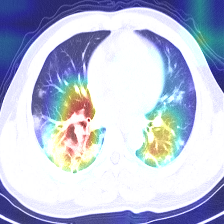

In [ ]:
produce_cam(path = covid1)

Prediction : Covid


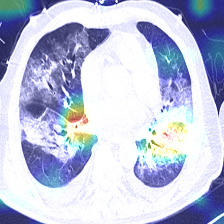

In [ ]:
produce_cam(path = covid2)

### CAM on Non Covid CT SCans

Prediction : Non Covid


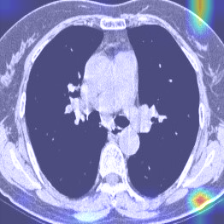

In [ ]:
produce_cam(path = non_covid1)

Prediction : Non Covid


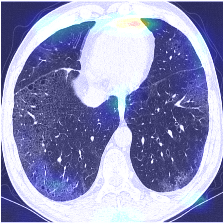

In [ ]:
produce_cam(path = non_covid2)